#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96 #  (submerged) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 169 # [m]
Xg = 78 # [m]
mn = 123000000 # 32219000   # mass of the vessel, [kg]  Solitaire type vessel 
kp, kd=1.95e4,1.5e4

In [8]:
vessel_mass=mn/L # mass over length of vessel

In [9]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [10]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [11]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [12]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [13]:
Irho+=vessel_inertia

In [14]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [15]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [16]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [17]:
DT=np.diag(diag_DT) # (35) in [2]

In [18]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [19]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [20]:
CT=np.diag(diag_CT)

In [21]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [22]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [23]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [24]:
rng = np.random.default_rng()

In [25]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [26]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [27]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.7602395 ,  0.50380347, -0.41014383],
       [-0.63436944,  0.43961653, -0.63585589],
       [-0.1400404 ,  0.74358548,  0.65381138]])

In [28]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.008181


In [29]:
Ret.shape

(50, 3, 3)

In [30]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [31]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))) 
    return ans.T

In [32]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000355


In [33]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [34]:
fD(dx,dy,dz,DT,Ret).T

array([[ -6257.33327678,   7787.22723775, -13895.12341563],
       [ -4928.92157495, -10114.45134888,  -7655.06892392],
       [ -4820.12162431,    526.15254999,  -4251.60384742],
       [  9025.4975234 ,   4417.21052123,  -3959.94925095],
       [-34011.93177673,  15789.08636727, -26829.93823771],
       [-21671.34525261,   9466.81408063,   1927.98129626],
       [  4848.56945457,   9175.35571397,   1418.28341944],
       [  3506.71225521,   4348.23555503,   8649.35884137],
       [  2380.36960037,   2772.93604514,   4348.48219263],
       [  -563.37321144,   -589.78647118,   -338.82850578],
       [-49576.62471926, -42104.80761384,  44174.35837896],
       [  7420.60932349,  -5766.99691477,  25421.7938346 ],
       [ 17887.34355854, -17213.93621934,  -1717.49465917],
       [  4210.26013289,  -5772.76546465,  -4660.80715459],
       [ -2327.54062864,  -4007.9155824 ,   -257.12368603],
       [ 19116.568382  ,   2402.00175498, -10383.33616205],
       [  5465.89614392,   9278.63319656

In [35]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.001278


In [36]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [37]:
I=np.identity(3)

In [38]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000364


In [39]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [40]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [41]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [42]:
DR=np.diag(diag_DR) 

In [43]:
Ar

0.08091250419136858

In [44]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [45]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [46]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)

In [47]:
def Re_b(Ret):
    return Ret

In [48]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000135


In [49]:
def phi(x, y, z, Ret,dummy):
    B=np.vstack([x,y,z])
    return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))

In [50]:
phi(x,y,z,Ret,None)

array([[ -24.30726714,  -78.94577907,  193.10310723],
       [ 136.33492107,  -34.06953269,   37.03880075],
       [-163.57860572,  -37.8888563 ,   89.37770374],
       [  23.8788059 ,   -3.45935645,  -39.02639222],
       [  19.19332896,   -4.61765519,  -16.55156668],
       [   8.52515343,  -73.76242725,   66.82363752],
       [  78.02441917,  -71.97194084,  -10.46338773],
       [ 173.07406556, -107.29774852,   -9.5956888 ],
       [  50.56886186,  -70.59068052,  -20.29261142],
       [-157.16758959,   15.2528622 , -153.14007578],
       [ -41.30784258,   32.63365198, -143.54970775],
       [ 125.43890169,  -38.06588974,  -61.83476119],
       [ -64.90512197, -218.55921898, -108.39166492],
       [-145.72914648,   88.63256633,  -28.42960878],
       [ -47.23734643, -180.77813679,   36.24614187],
       [ 199.93034105,    6.56325952, -113.0837583 ],
       [ -65.96888421,   -9.35186717,   49.1612304 ],
       [-169.26054288,  -28.76674877, -141.39939797],
       [  89.5769274 , -170.

In [51]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None)
print(datetime.now() - startTime1)

0:00:00.001086


In [52]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [53]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [54]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.002103


In [55]:
def ωe(φ,θ,ψ, dummy,dummy1):  # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float32))

In [56]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None)
print(datetime.now() - startTime1)

0:00:00.008813


In [57]:
ωe(φ,θ,ψ,None,None)

array([[ 0.87567911, -0.01458235, -0.06622337],
       [ 0.79924437,  0.16434966, -0.00719   ],
       [-0.65398363,  0.218672  ,  1.12397728],
       [ 0.2875481 ,  1.95372758,  0.72724608],
       [-0.68438824,  0.59696119, -0.60910637],
       [ 0.27355233, -2.09085806,  0.4523501 ],
       [ 0.29056699, -0.11176485, -0.98517151],
       [-0.02700312, -1.22450681, -2.40242477],
       [ 0.67813613, -0.34879813,  1.26948828],
       [-0.34784621, -0.49162857,  0.43746199],
       [ 0.7204161 ,  0.65076948, -0.37687183],
       [-1.13021375,  0.59116816,  0.63726534],
       [-0.21674137, -0.78097087, -0.64155185],
       [-0.43206236,  1.76419855,  1.19891122],
       [ 1.6061575 , -1.14013055,  0.46918514],
       [ 0.54382748,  0.1209919 , -0.02375533],
       [-0.70486223, -1.79707892, -1.14853936],
       [-0.78662207, -0.14897314, -1.81788042],
       [ 0.28800556, -1.0324146 , -0.02019625],
       [ 0.27891461,  1.39680136,  1.19178237],
       [-0.99331574,  0.33475559, -0.057

In [58]:
def d_s(f,a,b,c,Ret,omega):

    fun = f(a,b,c,Ret,omega)    
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    K=np.apply_along_axis(S, 1, omega)

    return np.einsum('ijk,ik->ij',K,fun.astype(np.float32)).T

In [59]:
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[  -8.04395305,    5.84235429,   62.13061244,  -73.73113859,
         -12.69328636, -106.35230187,  -69.73526525, -246.02477354,
          96.69206963,   68.61548979,  -81.11906875,  -12.2966695 ,
         -55.56634027, -156.4180561 ,   43.49307991,  -13.52630584,
         -99.08760058,  -31.22979681,   30.33708926,  156.31014965,
           3.31146812,  -58.82579698,   21.94907085,  -44.45274705,
         -82.54026253, -187.80468822,  331.25682909,   43.96160018,
         -75.2971697 ,    0.56939539,  -99.36200904,   32.8881749 ,
         558.91614629, -143.90866499, -245.5585191 , -112.3560776 ,
         159.62170724,  107.49792064,  -16.99182317,  -61.34180047,
         -30.30819378,  -21.35745215,   38.41732267,   91.98912973,
         212.15116763,  -33.97952082,  223.26578202,   65.65071253,
          96.05589548,  -22.28844408],
       [-167.48664532,  -30.58329934, -125.40709222,   28.58773294,
         -23.01847671,  -14.42340814,  -73.82712258, -416.05653726,
         

In [60]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.005704


In [61]:
def ne(x,y,z,Ret,omega):
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float32),B-
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float32), np.array([1,0,0]).reshape(3,1)).squeeze())

In [62]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [63]:
ne_(dx,dy,dz,DT,Ret)

array([[  6257.33327678,   4928.92157495,   4820.12162431,
         -9025.4975234 ,  34011.93177673,  21671.34525261,
         -4848.56945457,  -3506.71225521,  -2380.36960037,
           563.37321144,  49576.62471926,  -7420.60932349,
        -17887.34355854,  -4210.26013289,   2327.54062864,
        -19116.568382  ,  -5465.89614392,   4067.36038052,
        -20769.00659765, -11968.72845771,   -880.73589868,
         -6745.18310457,   2840.89138565,  -6774.60981999,
          2676.94955216,  -8990.62768947,   1425.55168536,
         17985.61738333,   -555.2642249 ,   3811.93175567,
          -779.93487719,    -76.09364308,    291.94361424,
         -3328.4792933 , -13991.13288835,  -9367.16777177,
            50.13263747,   7138.19219115,   1546.23915659,
        -13523.79636258,  -3368.60671108,  -5542.47196099,
         -7454.06605964,  -2427.84883161,    154.28134146,
          5888.45089884,   6978.37783233,  30048.50058112,
         -4534.78760288,   2226.2458164 ],
       [ -778

In [64]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.004472


In [65]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[-5.08850718e+09, -3.22463220e+10, -2.96431097e+10],
       [ 3.15364988e+09, -8.91182657e+09, -2.24063851e+10],
       [ 3.18277801e+09, -2.31865233e+09,  5.01565406e+10],
       [-1.13814746e+10,  1.38872200e+10, -3.67898986e+09],
       [-2.81948373e+09, -6.51967466e+09, -4.53940739e+09],
       [-2.78193949e+10, -8.40808912e+09, -9.61565700e+08],
       [-1.80303612e+10, -1.82532640e+10, -1.16414060e+10],
       [-1.73447494e+11, -2.29438748e+11,  1.74031775e+11],
       [ 4.97120009e+08,  1.39901775e+07, -2.49927892e+10],
       [ 3.63137897e+10, -8.37803937e+10, -6.10996834e+10],
       [-1.83592820e+10,  1.75020613e+10,  8.72838281e+09],
       [-1.38392646e+08,  3.72433193e+08, -1.30677316e+10],
       [-3.19268251e+10,  1.42932060e+10, -2.22524768e+09],
       [-1.34007605e+09, -4.46635286e+10,  4.86769221e+10],
       [ 1.81414018e+10, -2.22530539e+09, -3.10161223e+09],
       [-1.40753287e+10,  4.08155945e+10, -1.47088843e+10],
       [-1.35198552e+10,  5.98764134e+10

In [66]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000428


In [67]:
Re_b(Ret).shape

(50, 3, 3)

In [68]:
def Irho_e(Ret):
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans

In [69]:
Irho_e(Ret).shape

(50, 3, 3)

In [70]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000508


In [71]:
diag_CR = 1e11*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [72]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [73]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,None,omega)
 
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [74]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.006170


In [75]:
d_me_

array([[ 1.76187222e+00,  8.41541563e+00,  1.31323447e+01],
       [-9.30305072e-01,  6.78878756e+00,  1.70451405e+02],
       [ 4.26359843e+01, -2.73241478e+01,  6.36615625e+02],
       [ 4.24512603e+02, -4.86945949e+02,  1.31021942e+02],
       [ 3.16195762e+02, -9.46387309e+01, -1.11969226e+03],
       [-1.25946745e+03, -1.23337696e+02,  6.38574624e+02],
       [-1.90747227e+01,  1.84403993e+02, -1.00540722e+02],
       [-3.83360664e+03, -7.77529979e+01,  1.07529444e+02],
       [-1.53392644e+01, -1.09354114e+00, -5.04072631e+01],
       [ 6.80411653e+02, -3.31443545e+02,  3.43471537e+02],
       [-6.02851714e+01, -1.60920220e+02, -4.11736463e+02],
       [-1.63250732e+01, -3.94050931e+01, -7.20957532e+02],
       [ 1.45110336e+02, -1.50348375e+02,  8.38320557e+01],
       [-3.59187817e+01, -2.42818695e+02, -2.61687760e+00],
       [-8.66078282e+02,  2.29394343e+01,  8.10017031e+01],
       [-5.78818249e+00,  5.09230519e+01,  1.59887281e+02],
       [ 6.54969174e+02, -2.12518483e+03

In [76]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [77]:
ne_(dx,dy,dz,DT,Ret)

array([[  6257.33327678,   4928.92157495,   4820.12162431,
         -9025.4975234 ,  34011.93177673,  21671.34525261,
         -4848.56945457,  -3506.71225521,  -2380.36960037,
           563.37321144,  49576.62471926,  -7420.60932349,
        -17887.34355854,  -4210.26013289,   2327.54062864,
        -19116.568382  ,  -5465.89614392,   4067.36038052,
        -20769.00659765, -11968.72845771,   -880.73589868,
         -6745.18310457,   2840.89138565,  -6774.60981999,
          2676.94955216,  -8990.62768947,   1425.55168536,
         17985.61738333,   -555.2642249 ,   3811.93175567,
          -779.93487719,    -76.09364308,    291.94361424,
         -3328.4792933 , -13991.13288835,  -9367.16777177,
            50.13263747,   7138.19219115,   1546.23915659,
        -13523.79636258,  -3368.60671108,  -5542.47196099,
         -7454.06605964,  -2427.84883161,    154.28134146,
          5888.45089884,   6978.37783233,  30048.50058112,
         -4534.78760288,   2226.2458164 ],
       [ -778

### Vessel

In [78]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

        self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA

    def eq_left(self,η, dη):
        return (np.matmul(self.D, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.dot(self.G,η))

In [79]:
V=VesselSemisub()

In [80]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [81]:
tau_force = V.tau(η,dη, ddη)

In [82]:
tau_force

array([0.00000e+00, 0.00000e+00, 2.40000e+06, 7.14800e+09, 1.57272e+10,
       0.00000e+00])

In [83]:
wave_coef=1

In [84]:
def Fx(x,dx, z,dz, t, kp, kd, x_ref = 0, dx_ref=0, z_ref = 0, dz_ref=0):
    return -kp*(x-x_ref) - kd*(dx-dx_ref)-kp*(z-z_ref) - kd*(dz-dz_ref)

In [85]:
Hs = 2.5 # significant wave height in m

In [86]:
def wave_force(Hs,d0,qw, Cd=1.2):
    g=9.81 
    return 0.5 * qw * g * Hs**2 * d0 * Cd

In [87]:
wave_force(Hs,d0,qw, Cd=1.2)

28695.1696875

In [88]:

def tau(η, dη, wave_coef, kp, kd,time, Hs=2.5, Tp=10, x_ref = 0, dx_ref=0, z_ref = 0, dz_ref=0):
    x,y,z,φ,θ,ψ=η
    dx,dy,dz,dφ,dθ,dψ=dη
    F=(np.array([-Fx(x,dx,z,dz,time, kp, kd, x_ref, dx_ref, z_ref, dz_ref),0,0])
       +wave_coef*np.array([0,0,wave_force(Hs,d0,qw)])*np.sin(2*np.pi/Tp*time+1)
      ).T
    ans=np.concatenate( [F,[0,0,0]], axis=0)
    return ans

In [89]:
tau(η, dη, wave_coef, kp, kd,3)

array([9750.        ,    0.        , 7283.67179881,    0.        ,
          0.        ,    0.        ])

### Static solution

In [90]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [91]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [92]:
Fx_0=82945396

In [93]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [94]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [95]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [96]:
delta_x=horizontal_length/(node_N-1)

In [97]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [98]:
x0,z0

([0.0,
  225.56499682574736,
  451.1299936514947,
  676.6949904772421,
  902.2599873029894,
  1127.8249841287368,
  1353.3899809544841,
  1578.9549777802315,
  1804.5199746059789,
  2030.0849714317262,
  2255.6499682574736,
  2481.2149650832207,
  2706.7799619089683,
  2932.344958734716,
  3157.909955560463,
  3383.47495238621,
  3609.0399492119577,
  3834.6049460377053,
  4060.1699428634524,
  4285.7349396892,
  4511.299936514947,
  4736.864933340695,
  4962.429930166441,
  5187.994926992189,
  5413.559923817937,
  5639.124920643684,
  5864.689917469432,
  6090.254914295178,
  6315.819911120926,
  6541.384907946674,
  6766.94990477242,
  6992.514901598168,
  7218.079898423915,
  7443.644895249663,
  7669.209892075411,
  7894.774888901157,
  8120.339885726905,
  8345.904882552652,
  8571.4698793784,
  8797.034876204147,
  9022.599873029894,
  9248.164869855642,
  9473.72986668139,
  9699.294863507137,
  9924.859860332883,
  10150.42485715863,
  10375.989853984378,
  10601.554850810126,

In [99]:
length_p

[225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 

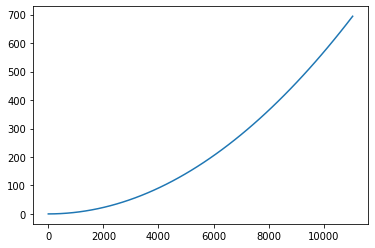

In [100]:
plt.plot(x0, z0)
plt.show()

In [101]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [102]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [103]:
def static_func(Q):
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)


    Z0=np.dot(Re_b(Ret),tau_force[:3])
#     Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
    Z1 = d_s(ne, x, y, z, Ret, test).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
############################################################    
    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
############################################################    

   
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None))
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################


    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
    return ans 

In [104]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [105]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [106]:
root

array([ 6.20781514e-01,  2.25660496e+02,  4.51487595e+02,  6.78101204e+02,
        9.02880012e+02,  1.12844501e+03,  1.35401001e+03,  1.57957500e+03,
        1.80514000e+03,  2.03070500e+03,  2.25626999e+03,  2.48183499e+03,
        2.70739999e+03,  2.93296498e+03,  3.15852998e+03,  3.38409498e+03,
        3.60965997e+03,  3.83522497e+03,  4.06078997e+03,  4.28635496e+03,
        4.51191996e+03,  4.73748496e+03,  4.96304996e+03,  5.18861495e+03,
        5.41417995e+03,  5.63974495e+03,  5.86530994e+03,  6.09087494e+03,
        6.31643994e+03,  6.54200493e+03,  6.76756993e+03,  6.99313493e+03,
        7.21869992e+03,  7.44426492e+03,  7.66982992e+03,  7.89539491e+03,
        8.12095991e+03,  8.34652491e+03,  8.57208990e+03,  8.79765490e+03,
        9.02321990e+03,  9.24878490e+03,  9.47434989e+03,  9.69991489e+03,
        9.92547989e+03,  1.01510449e+04,  1.03766099e+04,  1.06021749e+04,
        1.08277399e+04,  1.10533049e+04, -1.37673236e-16, -1.37673236e-16,
       -1.37673236e-16, -

In [107]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [108]:
x0

[0.0,
 225.56499682574736,
 451.1299936514947,
 676.6949904772421,
 902.2599873029894,
 1127.8249841287368,
 1353.3899809544841,
 1578.9549777802315,
 1804.5199746059789,
 2030.0849714317262,
 2255.6499682574736,
 2481.2149650832207,
 2706.7799619089683,
 2932.344958734716,
 3157.909955560463,
 3383.47495238621,
 3609.0399492119577,
 3834.6049460377053,
 4060.1699428634524,
 4285.7349396892,
 4511.299936514947,
 4736.864933340695,
 4962.429930166441,
 5187.994926992189,
 5413.559923817937,
 5639.124920643684,
 5864.689917469432,
 6090.254914295178,
 6315.819911120926,
 6541.384907946674,
 6766.94990477242,
 6992.514901598168,
 7218.079898423915,
 7443.644895249663,
 7669.209892075411,
 7894.774888901157,
 8120.339885726905,
 8345.904882552652,
 8571.4698793784,
 8797.034876204147,
 9022.599873029894,
 9248.164869855642,
 9473.72986668139,
 9699.294863507137,
 9924.859860332883,
 10150.42485715863,
 10375.989853984378,
 10601.554850810126,
 10827.119847635873,
 11052.68484446162]

In [109]:
x0_

array([6.20781514e-01, 2.25660496e+02, 4.51487595e+02, 6.78101204e+02,
       9.02880012e+02, 1.12844501e+03, 1.35401001e+03, 1.57957500e+03,
       1.80514000e+03, 2.03070500e+03, 2.25626999e+03, 2.48183499e+03,
       2.70739999e+03, 2.93296498e+03, 3.15852998e+03, 3.38409498e+03,
       3.60965997e+03, 3.83522497e+03, 4.06078997e+03, 4.28635496e+03,
       4.51191996e+03, 4.73748496e+03, 4.96304996e+03, 5.18861495e+03,
       5.41417995e+03, 5.63974495e+03, 5.86530994e+03, 6.09087494e+03,
       6.31643994e+03, 6.54200493e+03, 6.76756993e+03, 6.99313493e+03,
       7.21869992e+03, 7.44426492e+03, 7.66982992e+03, 7.89539491e+03,
       8.12095991e+03, 8.34652491e+03, 8.57208990e+03, 8.79765490e+03,
       9.02321990e+03, 9.24878490e+03, 9.47434989e+03, 9.69991489e+03,
       9.92547989e+03, 1.01510449e+04, 1.03766099e+04, 1.06021749e+04,
       1.08277399e+04, 1.10533049e+04])

In [110]:
z0

[0.0,
 0.2888428427924309,
 1.155373265710624,
 2.5995969523577234,
 4.621523375418674,
 7.221165796797117,
 10.398541267595833,
 14.15367062831231,
 18.486578508975636,
 23.39729332924428,
 28.885847298621222,
 34.95227641670818,
 41.59662047340119,
 48.81892304912524,
 56.619231515186364,
 64.99759703402582,
 73.9540745596112,
 83.48872283771031,
 93.60160440638002,
 104.29278559627915,
 115.56233653119654,
 127.41033112846175,
 139.83684709937523,
 152.8419659498538,
 166.4257729808412,
 180.58835728891447,
 195.3298117668901,
 210.65023310439128,
 226.54972178849314,
 243.02838210444648,
 260.0863221362252,
 277.72365376736735,
 295.94049268164,
 314.7369583638412,
 334.1131741005232,
 354.0692669808534,
 374.60536789741576,
 395.72161154711085,
 417.41813643197673,
 439.6950848601867,
 462.5526029468705,
 485.9908406151509,
 510.0099515971214,
 534.6100934348437,
 559.7914274813454,
 585.5541189017534,
 611.8983366742727,
 638.8242535914375,
 666.3320462610891,
 694.4218951076863]

In [111]:
z0_

array([6.83794572e-05, 2.88911204e-01, 1.15544150e+00, 2.59966484e+00,
       4.62159056e+00, 7.22123174e+00, 1.03986052e+01, 1.41537314e+01,
       1.84866348e+01, 2.33973434e+01, 2.88858895e+01, 3.49523093e+01,
       4.15966432e+01, 4.88189355e+01, 5.66192342e+01, 6.49975912e+01,
       7.39540615e+01, 8.34887040e+01, 9.36015812e+01, 1.04292759e+02,
       1.15562308e+02, 1.27410301e+02, 1.39836817e+02, 1.52841935e+02,
       1.66425743e+02, 1.80588328e+02, 1.95329783e+02, 2.10650206e+02,
       2.26549696e+02, 2.43028357e+02, 2.60086299e+02, 2.77723632e+02,
       2.95940472e+02, 3.14736939e+02, 3.34113156e+02, 3.54069250e+02,
       3.74605353e+02, 3.95721598e+02, 4.17418124e+02, 4.39695074e+02,
       4.62552593e+02, 4.85990832e+02, 5.10009944e+02, 5.34610087e+02,
       5.59791423e+02, 5.85554115e+02, 6.11898334e+02, 6.38824252e+02,
       6.66332046e+02, 6.94421896e+02])

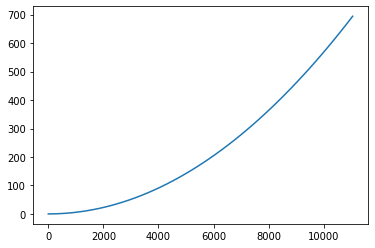

In [112]:
plt.plot(x0_, z0_)
plt.show()

In [113]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[j*node_N-1]=0.13  

In [114]:
q0

array([6.20781514e-01, 2.25660496e+02, 4.51487595e+02, 6.78101204e+02,
       9.02880012e+02, 1.12844501e+03, 1.35401001e+03, 1.57957500e+03,
       1.80514000e+03, 2.03070500e+03, 2.25626999e+03, 2.48183499e+03,
       2.70739999e+03, 2.93296498e+03, 3.15852998e+03, 3.38409498e+03,
       3.60965997e+03, 3.83522497e+03, 4.06078997e+03, 4.28635496e+03,
       4.51191996e+03, 4.73748496e+03, 4.96304996e+03, 5.18861495e+03,
       5.41417995e+03, 5.63974495e+03, 5.86530994e+03, 6.09087494e+03,
       6.31643994e+03, 6.54200493e+03, 6.76756993e+03, 6.99313493e+03,
       7.21869992e+03, 7.44426492e+03, 7.66982992e+03, 7.89539491e+03,
       8.12095991e+03, 8.34652491e+03, 8.57208990e+03, 8.79765490e+03,
       9.02321990e+03, 9.24878490e+03, 9.47434989e+03, 9.69991489e+03,
       9.92547989e+03, 1.01510449e+04, 1.03766099e+04, 1.06021749e+04,
       1.08277399e+04, 1.10533049e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

### Dynamics

In [115]:
def grayscott1d(t, Q):
    print(t)
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[(x0_[-1]-x[-1]),y[-1],(z0[-1]-z[-1]),φ[-1],θ[-1],ψ[-1]]
    dη=[dx[-1],dy[-1],dz[-1],dφ[-1],dθ[-1],dψ[-1]]
    
    left=V.eq_left(η,dη)
 
 
    
    # PD controller after 5 sec
    if t<5:
        ddη=np.linalg.lstsq(V.M.astype(np.float32), -left 
                            + tau(η, dη, wave_coef, 0, 0, t).astype(np.float32)
                            , rcond=None)[0]
    else:
        ddη=np.linalg.lstsq(V.M.astype(np.float32), -left.astype(np.float32) 
                            + tau(η,dη, wave_coef, kp, kd, t).astype(np.float32)
                            , rcond=None)[0]
    force_schedule = t/15 if t<15 else 1
#     force_schedule =1
    tau_force = force_schedule*V.tau(η,dη,ddη).astype(np.float32) # /1e3
    
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)


    Z0=np.dot(Re_b(Ret),tau_force[:3].reshape(3,1))

#     Z1 =d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
    Z1 =d_s(ne, x, y, z, Ret, test).T

    Z2=ne_(dx,dy,dz,DT,Ret).T
    
    Z= (Z1 + Z2 + Z0.squeeze())

############################################################    
    RRRR=Re_b(Ret)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',[Ws[i] for i in range(node_N-1)]
                                             +[vessel_mass]
                                             ,RRRR),Z).T
############################################################    

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))

    C2= np.cross(test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           test))

    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None)) 

#     C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
    C4= np.cross(d_s(phi,x,y,z,Ret, test).T, ne(x,y,z,Ret, test))

    
    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float32).T)

    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
       

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

    return A1111

In [116]:
tspan = (0., 10)

In [ ]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1, atol=1
            )
print(datetime.now() - startTime1)

0.0
0.00010444055243823689
0.002088811048764738
0.003133216573147107
0.008355244195058951
0.009283604661176613
0.01044405524382369
0.01044405524382369
0.03133216573147107
0.04177622097529476
0.09399649719441322
0.10328010185558982
0.11488460768206059
0.11488460768206059
0.1912283250515462
0.22940018373628895
0.42025947716000295
0.45419001821310756
0.4966031945294885
0.4966031945294885
0.588489252253926
0.6344322811161447
0.8641474254272384
0.9049856733047661
0.9560334831516759
0.9560334831516759
0.5717194138978487
0.6092775235820288
0.7970680720029294
0.8304530583888672
0.8721842913712896
0.8721842913712896
0.9473005107396498
0.98485862042383
1.1726491688447305
1.2060341552306684
1.2477653882130908
1.2477653882130908
0.9285301026426399
0.9567030082783151
1.0975675364566908
1.1226101192439577
1.1539133477280412
1.1539133477280412
1.2102591589993916
1.2384320646350666
1.3792965928134424
1.4043391756007093
1.4356424040847928
1.4356424040847928
1.4967985219427329
1.527376580871703
1.680266

3.7952337875707833
3.795434756288651
3.795434756288651
3.796140194642252
3.7964929138190526
3.798256509703055
3.798570037860211
3.798961948056656
3.798961948056656
3.799752431654268
3.800147673453074
3.8021238824471038
3.802475208490487
3.8029143660447158
3.8029143660447158
3.7993176241296807
3.799495462166193
3.800384652348755
3.8005427306034325
3.80074032842178
3.80074032842178
3.8010960044948043
3.801273842531317
3.802163032713879
3.802321110968556
3.8025187087869035
3.8025187087869035
3.803145432078685
3.803458793724576
3.8050256019540303
3.8053041456392664
3.805652325245812
3.805652325245812
3.8063343864311276
3.8066754170237855
3.808380569987075
3.80868370829166
3.8090626311723907
3.8090626311723907
3.805951560898375
3.806101178724657
3.8068492678560646
3.806982261479426
3.807148503508628
3.807148503508628
3.807447739161191
3.807597356987473
3.8083454461188806
3.808478439742242
3.808644681771444
3.808644681771444
3.8092756696300167
3.809591163559303
3.811168633205735
3.8114490722

3.880420847293329
3.878741072916851
3.8788241587038743
3.879239587638992
3.8793134416719015
3.879405759213039
3.879405759213039
3.879571930787086
3.8796550165741093
3.8800704455092268
3.8801442995421365
3.880236617083274
3.880236617083274
3.8805182311344377
3.88065903816002
3.8813630732879303
3.8814882350884474
3.881644687339094
3.881644687339094
3.881945676835654
3.8820961715839344
3.882848645325334
3.882982418434916
3.883149634821894
3.883149634821894
3.881779070702268
3.8818462623838546
3.882182220791789
3.8822419467309772
3.882316604154963
3.882316604154963
3.8824509875181366
3.8825181791997236
3.8828541376076577
3.882913863546846
3.8829885209708315
3.8829885209708315
3.883282748502551
3.8834298622684105
3.884165431097709
3.8842961988895843
3.8844596586294284
3.8844596586294284
3.8848074814167997
3.8849813928104857
3.885850949778914
3.8860055376844125
3.8861987725662854
3.8861987725662854
3.884616219167039
3.8846944994358448
3.8850859007798717
3.8851554832410318
3.8852424613174823


3.9238143412491535
3.9238951932573434
3.9239962582675805
3.9239962582675805
3.9241922363284356
3.924290225358863
3.9247801705110015
3.9248672718713813
3.9249761485718566
3.9249761485718566
3.9240854298354657
3.9241300156194083
3.9243529445391214
3.9243925763470706
3.9244421161070067
3.9244421161070067
3.924531287674892
3.9245758734588345
3.9247988023785476
3.924838434186497
3.924887973946433
3.924887973946433
3.925079224372684
3.92517484958581
3.9256529756514382
3.9257379758408835
3.9258442260776896
3.9258442260776896
3.926070259717903
3.92618327653801
3.926748360638544
3.926848820034194
3.926974394278757
3.926974394278757
3.9259459383583306
3.9259967944986514
3.9262510752002546
3.9262962806583173
3.9263527874808957
3.9263527874808957
3.9264544997615367
3.9265053559018575
3.9267596366034607
3.9268048420615234
3.9268613488841018
3.9268613488841018
3.927039207638366
3.9271281370154982
3.9275727839011587
3.927651832236387
3.9277506426554227
3.9277506426554227
3.9279438896708063
3.92804051

3.953971482061663
3.954004861075796
3.9541717561464584
3.9542014263812426
3.9542385141747234
3.9542385141747234
3.9543812290610316
3.9544525865041855
3.954809373719956
3.9548728025583153
3.954952088606264
3.954952088606264
3.9551204091674683
3.9552045694480706
3.955625370851082
3.9557001799893947
3.955793691412286
3.955793691412286
3.955027874298874
3.9550657671451788
3.9552552313767038
3.9552889139067524
3.9553310170693137
3.9553310170693137
3.9554068027619236
3.9554446956082288
3.9556341598397533
3.955667842369802
3.955709945532363
3.955709945532363
3.955842300915878
3.9559084786076357
3.9562393670664235
3.956298191681319
3.9563717224499384
3.9563717224499384
3.9565161487279936
3.9565883618670212
3.956949427562159
3.957013617019072
3.957093853840214
3.957093853840214
3.95643604303194
3.9564682033229404
3.9566290047779438
3.956657591703278
3.9566933253599452
3.9566933253599452
3.9567576459419467
3.956789806232947
3.9569506076879506
3.9569791946132846
3.957014928269952
3.95701492826995

3.9776120004072686
3.9779525163491236
3.9780130525165642
3.9780887227258654
3.9780887227258654
3.977468991849684
3.9774996423534486
3.977652894872269
3.977680139764504
3.9777141958797975
3.9777141958797975
3.977775496887326
3.9778061473910897
3.9779593999099108
3.9779866448021455
3.978020700917439
3.978020700917439
3.9781245676055197
3.97817650094956
3.978436167669761
3.978482330642241
3.9785400343578416
3.9785400343578416
3.978652511200067
3.9787087496211795
3.9789899417267423
3.9790399314343983
3.9791024185689676
3.9791024185689676
3.9785922936226523
3.978618423255057
3.9787490714170834
3.9787722977569993
3.978801330681894
3.978801330681894
3.978853589946705
3.9788797195791097
3.979010367741136
3.9790335940810517
3.9790626270059466
3.9790626270059466
3.979172370378582
3.9792272420649004
3.97950160049649
3.979550375328772
3.9796113438691254
3.9796113438691254
3.9797410056688634
3.9798058365687328
3.980129991068078
3.9801876185346283
3.980259652867816
3.980259652867816
3.97966936433968

3.9959698234547156
3.996020938293916
3.996046495713516
3.9961742828115163
3.9961970005178276
3.9962253976507167
3.9962253976507167
3.9963112702784302
3.996354206592287
3.9965688881615713
3.9966070537738885
3.996654760789285
3.996654760789285
3.9967477901956596
3.996794304898847
3.997026878414784
3.997068224817617
3.997119907821159
3.997119907821159
3.9966987235045317
3.996720704862155
3.9968306116502728
3.996850150634827
3.9968745743655196
3.9968745743655196
3.9969185370807665
3.99694051843839
3.9970504252265076
3.997069964211062
3.9970943879417544
3.9970943879417544
3.9971852954169047
3.9972307491544803
3.9974580178423564
3.997498421164645
3.9975489253175067
3.9975489253175067
3.997656186731206
3.997709817438056
3.997977970972304
3.9980256427117262
3.9980852323860034
3.9980852323860034
3.9975966022845304
3.997620440768042
3.9977396331856014
3.997760822948723
3.997787310152625
3.997787310152625
3.997834987119649
3.997858825603161
3.99797801802072
3.9979992077838413
3.9980256949877435
3

4.0121596115153215
4.012176598243141
4.012197831652917
4.012197831652917
4.012236051790512
4.01225516185931
4.012350712203299
4.0123676989311186
4.012388932340894
4.012388932340894
4.012468076242762
4.012507648193695
4.012705507948366
4.0127406830158625
4.012784651850233
4.012784651850233
4.012877176587385
4.012923438955961
4.013154750798841
4.013195872904242
4.013247275535993
4.013247275535993
4.01282625241513
4.012847052697578
4.012951054109819
4.012969543249773
4.012992654674716
4.012992654674716
4.013034255239613
4.01305505552206
4.013159056934302
4.013177546074256
4.0132006574991985
4.0132006574991985
4.013275615389076
4.0133130943340145
4.013500489058709
4.013533803676432
4.013575446948586
4.013575446948586
4.013658686056208
4.013700305610019
4.013908403379075
4.013945398538017
4.013991642486697
4.013991642486697
4.01361189889965
4.013630124875181
4.01372125475284
4.013737455619979
4.013757706703903
4.013757706703903
4.013794158654967
4.013812384630499
4.013903514508157
4.0139197

4.026149204981126
4.026149204981126
4.02618191588944
4.026198271343596
4.026280048614382
4.026294586795855
4.026312759522696
4.026312759522696
4.026381577331178
4.026415986235419
4.026588030756623
4.026618616449282
4.026656848565105
4.026656848565105
4.026737930416291
4.026778471341884
4.026981175969849
4.027017212348154
4.027062257821035
4.027062257821035
4.026693273847547
4.026711486488768
4.026802549694873
4.0268187387092915
4.026838974977315
4.026838974977315
4.026875400259756
4.026893612900977
4.026984676107082
4.027000865121501
4.027021101389524
4.027021101389524
4.027086409734611
4.027119063907155
4.027282334769873
4.027311360701023
4.02734764311496
4.02734764311496
4.027419829181099
4.027455922214168
4.0276363873795145
4.027668470075576
4.027708573445653
4.027708573445653
4.027379208853028
4.027394991722062
4.027473906067231
4.0274879352841495
4.0275054718052985
4.0275054718052985
4.027537037543366
4.0275528204124
4.027631734757569
4.027645763974488
4.027663300495637
4.02766330

4.038451154963605
4.0385337968521675
4.0385484887434675
4.038566853607593
4.038566853607593
4.03862289556676
4.038650916546343
4.0387910214442595
4.038815928981667
4.038847063403426
4.038847063403426
4.038908506675787
4.038939228311967
4.039092836492867
4.039120144613917
4.039154279765228
4.039154279765228
4.03887637330609
4.038891028257423
4.038964303014082
4.038977329637489
4.038993612916746
4.038993612916746
4.03902292281941
4.039037577770742
4.039110852527402
4.039123879150809
4.0391401624300665
4.0391401624300665
4.039199674824467
4.039229431021668
4.039378212007669
4.039404661960736
4.03943772440207
4.03943772440207
4.0395075265321445
4.039542427597182
4.039716932922366
4.039747956091288
4.039786735052441
4.039786735052441
4.039468638865935
4.039484096097867
4.039561382257528
4.0395751220192455
4.039592296721392
4.039592296721392
4.039623211185257
4.039638668417188
4.03971595457685
4.039729694338567
4.039746869040714
4.039746869040714
4.039806599721149
4.039836465061366
4.0399857

4.049423653840676
4.0494393773049495
4.0494393773049495
4.049493448375637
4.049520483910982
4.0496556615877015
4.0496796931746735
4.049709732658389
4.049709732658389
4.049770447658865
4.049800805159103
4.049952592660294
4.04997957710495
4.0500133076607705
4.0500133076607705
4.049736914359161
4.049750505209547
4.049818459461476
4.049830540217375
4.049845641162248
4.049845641162248
4.04987282286302
4.049886413713406
4.049954367965335
4.049966448721234
4.049981549666107
4.049981549666107
4.050034424461037
4.050060861858502
4.050193048845828
4.050216548754686
4.050245923640758
4.050245923640758
4.050306966554198
4.050337488010919
4.050490095294521
4.050517225478272
4.050551138207961
4.050551138207961
4.0502725816161265
4.050285910603811
4.050352555542233
4.050364403531286
4.050379213517601
4.050379213517601
4.05040587149297
4.050419200480654
4.050485845419076
4.050497693408129
4.050512503394445
4.050512503394445
4.05056744020138
4.0505949086048485
4.050732250622189
4.050756666980827
4.0507

4.059233257875722
4.059243967666957
4.059257354905999
4.059257354905999
4.059306656393964
4.059331307137946
4.059454560857858
4.059476472630287
4.059503862345823
4.059503862345823
4.059561422869074
4.0595902031307
4.059734104438828
4.059759686893607
4.05979166496208
4.05979166496208
4.059529650890228
4.05954254516243
4.059607016523444
4.059618478098735
4.059632805067849
4.059632805067849
4.059658593612255
4.059671487884457
4.0597359592454705
4.059747420820762
4.059761747789876
4.059761747789876
4.0598093818280905
4.059833198847198
4.059952283942732
4.059973454626383
4.059999917980947
4.059999917980947
4.060053288832207
4.060079974257837
4.060213401385987
4.060237121764325
4.060266772237247
4.060266772237247
4.060022981847675
4.060034513781039
4.0600921734478606
4.060102424055295
4.060115237314589
4.060115237314589
4.0601383011813175
4.060149833114682
4.060207492781503
4.060217743388938
4.060230556648231
4.060230556648231
4.060280807827002
4.060305933416388
4.060431561363317
4.060453895

4.068229272836248
4.068229272836248
4.068271693335344
4.068292903584891
4.068398954832629
4.068417808387783
4.068441375331725
4.068441375331725
4.068487892978363
4.068511151801683
4.068627445918281
4.068648120427898
4.06867396356492
4.06867396356492
4.068462804591367
4.068473519221189
4.068527092370295
4.068536616485692
4.068548521629937
4.068548521629937
4.06856995088958
4.068580665519401
4.0686342386685075
4.068643762783904
4.06865566792815
4.06865566792815
4.068700633178143
4.068723115803139
4.068835528928122
4.068855513483674
4.0688804941781145
4.0688804941781145
4.06893358162017
4.0689601253411976
4.069092843946335
4.069116438365027
4.069145931388391
4.069145931388391
4.068904273987784
4.06891616389262
4.068975613416796
4.068986182221093
4.068999393226465
4.068999393226465
4.069023173036135
4.069035062940971
4.0690945124651465
4.069105081269444
4.069118292274816
4.069118292274816
4.069161605124386
4.069183261549172
4.069291543673098
4.069310793828462
4.069334856522668
4.0693348565

4.076640534981786
4.076640534981786
4.076686830602219
4.076709978412435
4.076825717463515
4.076846293294818
4.076872013083947
4.076872013083947
4.076661176338035
4.07667149701616
4.076723100406783
4.076732274342893
4.076743741763032
4.076743741763032
4.076764383119281
4.076774703797406
4.076826307188028
4.076835481124139
4.0768469485442775
4.0768469485442775
4.076887773894232
4.076908186569209
4.077010249944095
4.077028394544075
4.07705107529405
4.07705107529405
4.0770983896581345
4.077122046840177
4.07724033275039
4.0772613613566495
4.077287647114474
4.077287647114474
4.077071973953496
4.077082423283219
4.077134669931833
4.077143958224919
4.077155568591278
4.077155568591278
4.077176467250724
4.077186916580446
4.077239163229061
4.077248451522148
4.077260061888507
4.077260061888507
4.077301419590605
4.077322098441655
4.077425492696903
4.077443873897836
4.077466850399001
4.077466850399001
4.077514114578202
4.077537746667803
4.077655907115805
4.077676913417672
4.077703171295005
4.07770317

4.0844521046582685
4.0844521046582685
4.084245502213488
4.084255693920941
4.0843066524582055
4.084315711753718
4.084327035873111
4.084327035873111
4.084347419288016
4.084357610995469
4.084408569532734
4.0844176288282465
4.084428952947639
4.084428952947639
4.084465941807587
4.084484436237561
4.084576908387432
4.084593347880743
4.08461389724738
4.08461389724738
4.084655129845199
4.084675746144109
4.084778827638656
4.0847971532376866
4.084820060236475
4.084820060236475
4.084631907163056
4.084640912120894
4.084685936910082
4.084693941317049
4.0847039468257575
4.0847039468257575
4.084721956741433
4.084730961699271
4.084775986488459
4.084783990895426
4.084793996404135
4.084793996404135
4.084833298518175
4.084852949575196
4.084951204860298
4.084968672466538
4.084990506974338
4.084990506974338
4.085036925679499
4.08506013503208
4.085176181794982
4.085196812330609
4.085222600500143
4.085222600500143
4.085011381086793
4.085021818143021
4.085074003424158
4.0850832808074715
4.085094877536613
4.085

4.091472550357389
4.09149618370395
4.09149618370395
4.091302524720589
4.091312045288433
4.091359648127651
4.0913681108546225
4.091378689263338
4.091378689263338
4.0913977303990245
4.091407250966868
4.091454853806086
4.091463316533058
4.091473894941773
4.091473894941773
4.09150867553519
4.091526065831899
4.091613017315442
4.091628475356961
4.091647797908859
4.091647797908859
4.091686468179739
4.091705803315179
4.091802478992378
4.091819665779435
4.091841149263257
4.091841149263257
4.091664475108435
4.0916728137082226
4.091714506707162
4.091721918795862
4.091731183906738
4.091731183906738
4.091747861106314
4.091756199706102
4.091797892705041
4.091805304793741
4.091814569904617
4.091814569904617
4.091851307916404
4.091869676922298
4.091961521951765
4.091977849957003
4.091998259963551
4.091998259963551
4.092041755507814
4.092063503279945
4.092172242140601
4.092191573493606
4.092215737684863
4.092215737684863
4.092017804723837
4.09202757710398
4.092076439004693
4.09208512556482
4.0920959837

4.098073920851468
4.098073920851468
4.097892610122695
4.0979015035965105
4.097945970965587
4.097953876275645
4.0979637579132175
4.0979637579132175
4.097981544860848
4.097990438334663
4.09803490570374
4.098042811013798
4.09805269265137
4.09805269265137
4.098085472917547
4.098101863050636
4.098183813716079
4.098198382723269
4.098216593982256
4.098216593982256
4.098253099061419
4.098271351601001
4.09836261429891
4.0983788387785385
4.098399119378073
4.098399119378073
4.098232509401604
4.098240467111278
4.098280255659649
4.0982873291793585
4.098296171078997
4.098296171078997
4.098312086498344
4.098320044208019
4.0983598327563895
4.098366906276099
4.098375748175737
4.098375748175737
4.098409820201461
4.0984268562143225
4.09851203627863
4.098527179401174
4.098546108304354
4.098546108304354
4.098586278275768
4.098606363261475
4.098706788190011
4.098724641510639
4.098746958161425
4.098746958161425
4.098564188823918
4.0985732290837
4.09861843038261
4.098626466169082
4.098636510902174
4.098636510

4.104262763717657
4.104262763717657
4.104089993520057
4.104098538845601
4.1041412654733165
4.104148861318244
4.104158356124403
4.104158356124403
4.104175446775489
4.104183992101032
4.104226718728748
4.1042343145736755
4.104243809379835
4.104243809379835
4.104273554777238
4.10428842747594
4.104362790969451
4.1043760111460745
4.104392536366855
4.104392536366855
4.104425337181977
4.104441737589539
4.104523739627346
4.104538317767401
4.104556540442469
4.104556540442469
4.104407679270779
4.104415250722741
4.104453107982551
4.104459838162073
4.104468250886476
4.104468250886476
4.1044833937904
4.104490965242362
4.104528822502172
4.1045355526816945
4.104543965406097
4.104543965406097
4.104575527720137
4.104591308877156
4.104670214662254
4.104684242357383
4.1047017769762935
4.1047017769762935
4.104738955246444
4.104757544381519
4.104850490056895
4.104867013732518
4.104887668327046
4.104887668327046
4.104718417041373
4.104726737073913
4.104768337236614
4.104775732821094
4.104784977301693
4.10478

4.109972043735436
4.109979105873119
4.109987933545224
4.109987933545224
4.110003823355012
4.1100117682599056
4.110051492784376
4.11005855492206
4.110067382594164
4.110067382594164
4.11009633257399
4.110110807563903
4.110183182513467
4.110196049171167
4.1102121324932925
4.1102121324932925
4.1102442960069725
4.110260377763812
4.110340786548011
4.11035508144298
4.110372950061691
4.110372950061691
4.110225956438772
4.110232868411512
4.110267428275213
4.110273572250982
4.110281252220693
4.110281252220693
4.110295076166173
4.110301988138913
4.110336548002613
4.110342691978382
4.110350371948093
4.110350371948093
4.110381087069323
4.110396444629937
4.11047323243301
4.110486883598002
4.11050394755424
4.11050394755424
4.110540368067602
4.110558578324282
4.1106496296076855
4.110665816502513
4.110686050121047
4.110686050121047
4.110520284046683
4.110528452292904
4.110569293524011
4.110576554187319
4.1105856300164545
4.1105856300164545
4.110601966508898
4.1106101347551185
4.110650975986226
4.110658

4.115459503100055
4.115493905059915
4.11550002096389
4.115507665843859
4.115507665843859
4.1155214266278035
4.115528307019775
4.115562708979635
4.11556882488361
4.115576469763579
4.115576469763579
4.1156048820353135
4.115619088171181
4.115690118850518
4.115702746526844
4.115718531122252
4.115718531122252
4.115751793414981
4.115768424561345
4.115851580293168
4.115866363534381
4.115884842585897
4.115884842585897
4.115733443173928
4.115740899199766
4.115778179328955
4.115784806907478
4.115793091380631
4.115793091380631
4.115808003432307
4.115815459458145
4.115852739587334
4.115859367165857
4.11586765163901
4.11586765163901
4.115894927134625
4.1159085648824325
4.115976753621469
4.115988876063965
4.116004029117084
4.116004029117084
4.116034520536002
4.11604976624546
4.116125994792754
4.116139546534495
4.116156486211672
4.116156486211672
4.116017242710647
4.116023849507429
4.116056883491337
4.116062756199588
4.116070097084901
4.116070097084901
4.116083310678464
4.116089917475246
4.1161229514

4.120692833431313
4.1206991076277095
4.120730478609692
4.120736055673156
4.120743027002486
4.120743027002486
4.120755575395279
4.120761849591675
4.120793220573658
4.120798797637121
4.120805768966451
4.120805768966451
4.120833352178506
4.120847143784533
4.12091610181467
4.120928361020027
4.120943685026725
4.120943685026725
4.120976379116403
4.120992726161242
4.121074461385437
4.12108899209196
4.121107155475115
4.121107155475115
4.120958369490933
4.120965711723038
4.121002422883559
4.121008949312096
4.121017107347767
4.121017107347767
4.121031791811975
4.12103913404408
4.121075845204602
4.121082371633139
4.12109052966881
4.12109052966881
4.121115627908965
4.121128177029043
4.121190922629431
4.121202077402834
4.1212160208695865
4.1212160208695865
4.121243415059911
4.121257112155074
4.121325597630885
4.1213377728265845
4.121352991821209
4.121352991821209
4.121228811833434
4.121235207315357
4.121267184724975
4.121272869597797
4.1212799756888225
4.1212799756888225
4.12129276665267
4.12129916

4.1257241626342465
4.125731933567252
4.125731933567252
4.125745921246661
4.125752915086366
4.12578788428489
4.1257941010312935
4.125801871964299
4.125801871964299
4.125825849932476
4.125837838916565
4.125897783837009
4.125908440711754
4.125921761805186
4.125921761805186
4.125948003694806
4.125961124639616
4.126026729363668
4.126038392425722
4.126052971253288
4.126052971253288
4.125934019509982
4.12594014836238
4.125970792624369
4.125976240493168
4.1259830503291655
4.1259830503291655
4.1259953080339615
4.12600143688636
4.126032081148349
4.126037529017148
4.126044338853145
4.126044338853145
4.126069770024404
4.126082485610032
4.1261460635381795
4.126157366280961
4.126171494709438
4.126171494709438
4.126201526311465
4.126216542112478
4.126291621117544
4.126304968496223
4.126321652719571
4.126321652719571
4.126184850478077
4.126191528362396
4.126224917783993
4.126230853681166
4.126238273552632
4.126238273552632
4.1262516293212705
4.12625830720559
4.126291696627187
4.12629763252436
4.126305

4.130503210307639
4.130534941361776
4.130540582438067
4.130547633783431
4.130547633783431
4.130571891517696
4.130584020384829
4.130644664720491
4.13065544593572
4.130668922454756
4.130668922454756
4.130696289078415
4.130709972390244
4.13077838894939
4.130790551893239
4.130805755573049
4.130805755573049
4.13068109480844
4.130687180985282
4.130717611869493
4.130723021804464
4.130729784223177
4.130729784223177
4.130741956576861
4.130748042753703
4.130778473637913
4.130783883572884
4.130790645991597
4.130790645991597
4.130814792693791
4.130826866044886
4.130887232800369
4.13089796466801
4.130911379502562
4.130911379502562
4.130939356758149
4.130953345385942
4.13102328852491
4.131035722860726
4.1310512657804965
4.1310512657804965
4.1309237594984065
4.130929949496328
4.130960899485938
4.1309664017063135
4.130973279481783
4.130973279481783
4.130985659477627
4.130991849475548
4.131022799465159
4.131028301685534
4.131035179461003
4.131035179461003
4.131059490855218
4.131071646552326
4.131132425

4.13505417972548
4.135086093695947
4.135091767290698
4.135098859284135
4.135098859284135
4.135120827673958
4.135131811868869
4.135186732843428
4.135196496572238
4.1352087012332515
4.1352087012332515
4.1352327672956735
4.135244800326884
4.1353049654829395
4.135315661510683
4.1353290315453615
4.1353290315453615
4.1352198892171135
4.135225483209045
4.135253453168701
4.135258425605973
4.135264641152563
4.135264641152563
4.135275829136425
4.135281423128357
4.135309393088013
4.135314365525285
4.135320581071875
4.135320581071875
4.1353438726535785
4.13535551844443
4.135413747398688
4.135424099212778
4.135437038980391
4.135437038980391
4.135464552655098
4.135478309492452
4.135547093679221
4.13555932197909
4.135574607353928
4.135574607353928
4.135449287144521
4.1354554112265856
4.135486031636909
4.135491475265412
4.135498279801039
4.135498279801039
4.135510527965169
4.135516652047234
4.135547272457558
4.13555271608606
4.135559520621688
4.135559520621688
4.135582428378782
4.135593882257329
4.135

4.139394893808904
4.139400258941159
4.139427084602437
4.139431853608886
4.139437814866947
4.139437814866947
4.139460635228053
4.139472045408606
4.139529096311372
4.139539238694085
4.1395519166724775
4.1395519166724775
4.139578786042762
4.139592220727905
4.139659394153616
4.139671336095965
4.139686263523901
4.139686263523901
4.139563975647262
4.1395700051346545
4.139600152571617
4.139605512115966
4.139612211546402
4.139612211546402
4.139624270521187
4.13963030000858
4.139660447445542
4.139665806989891
4.139672506420327
4.139672506420327
4.139693790509513
4.1397044325541055
4.13975764277707
4.139767102372264
4.139778926866256
4.139778926866256
4.139802451216698
4.139814213391919
4.139873024268024
4.139883479534887
4.139896548618466
4.139896548618466
4.139789571695915
4.139794894110745
4.139821506184892
4.139826237220295
4.13983215101455
4.13983215101455
4.139842795844209
4.139848118259039
4.139874730333186
4.139879461368589
4.139885375162844
4.139885375162844
4.139907946622866
4.13991923

4.143563728547558
4.143563728547558
4.143574065025417
4.143579233264346
4.1436050744589945
4.143609668449154
4.143615410936854
4.143615410936854
4.143637113250952
4.143647964408
4.143702220193244
4.143711865666177
4.143723922507342
4.143723922507342
4.143749500363401
4.1437622892914305
4.143826233931578
4.143837601867604
4.143851811787637
4.143851811787637
4.143735366095975
4.143741087890291
4.143769696861873
4.143774782901265
4.143781140450506
4.143781140450506
4.143792584039139
4.143798305833455
4.143826914805037
4.143832000844429
4.14383835839367
4.14383835839367
4.143859154106565
4.143869551963013
4.143921541245249
4.143930783784314
4.143942336958144
4.143942336958144
4.143965481146419
4.143977053240556
4.144034913711243
4.1440452000171435
4.144058057899518
4.144058057899518
4.143952392016497
4.143957419545673
4.143982557191555
4.143987026106379
4.1439926122499084
4.1439926122499084
4.1440026673082615
4.144007694837438
4.14403283248332
4.144037301398144
4.144042887541673
4.14404288

4.14758336775863
4.14758336775863
4.14759455309625
4.147600145765061
4.147628109109112
4.147633080370277
4.147639294446733
4.147639294446733
4.147658998267818
4.147668850178361
4.147718109731074
4.14772686698489
4.147737813552159
4.147737813552159
4.14775957102318
4.147770449758689
4.147824843436239
4.147834513423359
4.147846600907259
4.147846600907259
4.147747680354952
4.1477526137563485
4.147777280763331
4.147781666009017
4.147787147566124
4.147787147566124
4.1477970143689165
4.147801947770313
4.147826614777296
4.147831000022982
4.1478364815800886
4.1478364815800886
4.147857365976406
4.1478678081745635
4.147920019165356
4.147929301119275
4.147940903561673
4.147940903561673
4.1479655730493175
4.14797790779314
4.148039581512253
4.148050545728984
4.148064250999898
4.148064250999898
4.147951935458523
4.147957451406948
4.147985031149073
4.14798993421434
4.147996063045923
4.147996063045923
4.148007094942773
4.1480126108911985
4.148040190633323
4.14804509369859
4.1480512225301736
4.14805122

4.151488544571511
4.151493837162351
4.151493837162351
4.151513960311092
4.151524021885463
4.1515743297573175
4.15158327337898
4.151594452906059
4.151594452906059
4.151618235076523
4.151630126161756
4.151689581587917
4.151700151441456
4.151713363758381
4.151713363758381
4.151605063235679
4.1516103684004895
4.1516368942245405
4.151641609926594
4.151647504554161
4.151647504554161
4.151658114883781
4.151663420048592
4.151689945872643
4.151694661574696
4.151700556202263
4.151700556202263
4.151719905697144
4.151729580444584
4.151777954181787
4.151786553957289
4.151797303676668
4.151797303676668
4.151818830242158
4.151829593524903
4.1518834099386295
4.1518929773010695
4.15190493650412
4.15190493650412
4.151806588338515
4.151811230669439
4.151834442324056
4.151838568840432
4.151843726985903
4.151843726985903
4.15185301164775
4.151857653978674
4.151880865633291
4.151884992149667
4.151890150295138
4.151890150295138
4.1519106735139015
4.151920935123283
4.151972243170193
4.151981364600754
4.151992

4.155246694882793
4.15525593733171
4.155302149576293
4.155310365086441
4.155320634474126
4.155320634474126
4.155341064462719
4.155351279457014
4.155402354428495
4.155411434423425
4.1554227844170875
4.1554227844170875
4.15532972461245
4.155334269681612
4.155356995027422
4.155361035088899
4.1553660851657455
4.1553660851657455
4.155375175304069
4.155379720373231
4.155402445719041
4.155406485780518
4.155411535857365
4.155411535857365
4.155431101538191
4.155440884378604
4.155489798580669
4.155498494438815
4.155509364261496
4.155509364261496
4.155532528279118
4.15554411028793
4.155602020331987
4.15561231545093
4.155625184349609
4.155625184349609
4.155519680373884
4.155524838430079
4.155550628711051
4.15555521364989
4.155560944823439
4.155560944823439
4.155571260935828
4.155576418992022
4.1556022092729945
4.155606794211834
4.155612525385383
4.155612525385383
4.1556309813213845
4.155640209289386
4.1556863491293905
4.155694551767613
4.155704805065392
4.155704805065392
4.1557252252224695
4.15573

4.15891215459412
4.1589347174126114
4.158945998821858
4.159002405868089
4.159012433787418
4.15902496868658
4.15902496868658
4.15892212570091
4.158927111254305
4.158952039021279
4.158956470624297
4.158962010128069
4.158962010128069
4.158971981234859
4.158976966788254
4.159001894555228
4.159006326158246
4.159011865662018
4.159011865662018
4.1590297708306565
4.159038723414976
4.159083486336573
4.1590914441893005
4.159101391505211
4.159101391505211
4.159121222533613
4.1591311380478135
4.159180715618817
4.159189529409217
4.159200546647218
4.159200546647218
4.159110148600732
4.159114527148493
4.159136419887294
4.159140311929748
4.159145176982815
4.159145176982815
4.1591539340783354
4.159158312626095
4.159180205364898
4.159184097407351
4.159188962460418
4.159188962460418
4.159207889641507
4.159217353232051
4.159264671184772
4.159273083265256
4.15928359836586
4.15928359836586
4.159306006550822
4.159317210643303
4.159373231105709
4.1593831902990255
4.159395639290671
4.159395639290671
4.15929350

4.162394180630633
4.162413818038613
4.162423636742603
4.162472730262553
4.162481457999433
4.1624923676705325
4.1624923676705325
4.162402596641422
4.162406804646817
4.162427844673789
4.162431585123028
4.1624362606845775
4.1624362606845775
4.162444676695366
4.162448884700761
4.162469924727733
4.1624736651769725
4.162478340738522
4.162478340738522
4.162496906783685
4.162506189806265
4.1625526049191715
4.1625608564948
4.162571170964334
4.162571170964334
4.162593159197129
4.162604153313525
4.162659123895512
4.162668896443421
4.162681112128307
4.162681112128307
4.16258065962711
4.162585403958499
4.16260912561544
4.162613342798895
4.162618614278216
4.162618614278216
4.162628102940992
4.162632847272381
4.162656568929322
4.162660786112777
4.162666057592098
4.162666057592098
4.162683653685324
4.162692451731937
4.162736441965003
4.1627442624508815
4.162754038058229
4.162754038058229
4.162773702654214
4.162783534952207
4.16283269644217
4.162841436262608
4.162852361038155
4.162852361038155
4.162762

4.165791518401019
4.165801775234622
4.165853059402638
4.165862176588062
4.1658735730698435
4.1658735730698435
4.1657797149895766
4.165784070117458
4.165805845756866
4.16580971698165
4.16581455601263
4.16581455601263
4.165823266268394
4.165827621396275
4.165849397035683
4.165853268260467
4.165858107291447
4.165858107291447
4.165875797950668
4.165884643280278
4.16592886992833
4.16593673244354
4.165946560587551
4.165946560587551
4.165966964530574
4.165977166502084
4.166028176359639
4.16603724477876
4.166048580302661
4.166048580302661
4.165955196916683
4.165959515081249
4.165981105904077
4.16598494427258
4.165989742233209
4.165989742233209
4.165998378562341
4.166002696726906
4.166024287549734
4.1660281259182375
4.166032923878866
4.166032923878866
4.166050607198362
4.16605944885811
4.16610365715685
4.166111516409959
4.166121340476346
4.166121340476346
4.16614181250806
4.166152048523916
4.166203228603198
4.16621232728396
4.166223700634911
4.166223700634911
4.166129975905819
4.166134293620555

4.169085440950688
4.169092241676823
4.169092241676823
4.169041736584969
4.1690470873066445
4.169073840915022
4.169078597112067
4.169084542358373
4.169084542358373
4.169095243801724
4.1691005945234
4.169127348131777
4.169132104328822
4.169138049575128
4.169138049575128
4.169149501603755
4.169155227618069
4.169183857689637
4.169188947480137
4.169195309718264
4.169195309718264
4.169206817820376
4.169212571871431
4.1692413421267105
4.169246456838761
4.169252850228823
4.169252850228823
4.16926335643971
4.169268609545154
4.169294875072372
4.169299544499433
4.169305381283259
4.169305381283259
4.169314920334491
4.169319689860107
4.169343537488187
4.169347777066513
4.169353076539419
4.169353076539419
4.169363012903064
4.1693679810848865
4.1693928219939975
4.169397238155618
4.169402758357642
4.169402758357642
4.169414400012216
4.169420220839503
4.169449324975936
4.169454499044636
4.16946096663051
4.16946096663051
4.169473640741387
4.1694799777968266
4.1695116630740205
4.169517296012188
4.1695243

4.172264532001275
4.172270429458505
4.172277801280043
4.172277801280043
4.172293482444119
4.172301323026156
4.172340525936344
4.1723474953426
4.17235620710042
4.17235620710042
4.172287804746576
4.172292806479842
4.1723178151461715
4.172322261131297
4.172327818612704
4.172327818612704
4.172337822079236
4.172342823812502
4.172367832478832
4.172372278463958
4.1723778359453645
4.1723778359453645
4.1723911313435345
4.17239777904262
4.172431017538045
4.172436926603899
4.172444312936215
4.172444312936215
4.172457611826974
4.172464261272354
4.172497508499251
4.1725034191173656
4.172510807390009
4.172510807390009
4.172452692317732
4.17245688200849
4.17247783046228
4.172481554631843
4.172486209843797
4.172486209843797
4.172494589225313
4.172498778916071
4.1725197273698615
4.1725234515394245
4.172528106751378
4.172528106751378
4.1725421809171115
4.172549217999978
4.1725844034143105
4.172590658599081
4.172598477580044
4.172598477580044
4.172615051918835
4.172623339088231
4.17266477493521
4.1726721

4.175328743740699
4.1753358513307495
4.175344735818313
4.175344735818313
4.1753630195592955
4.175372161429786
4.175417870782243
4.175425996889347
4.175436154523226
4.175436154523226
4.175352845743468
4.175356900706046
4.175377175518933
4.175380779930113
4.175385285444088
4.175385285444088
4.175393395369244
4.175397450331821
4.175417725144708
4.175421329555888
4.175425835069864
4.175425835069864
4.1754415052506255
4.175449340341006
4.175488515792909
4.175495480317693
4.175504185973671
4.175504185973671
4.175522159915447
4.1755311468863345
4.175576081740773
4.17558407015934
4.175594055682549
4.175594055682549
4.175511977928524
4.175515873905951
4.175535353793083
4.175538816884129
4.175543145747936
4.175543145747936
4.175550937702789
4.175554833680215
4.175574313567347
4.175577776658393
4.1755821055222
4.1755821055222
4.1755984044217795
4.17560655387157
4.175647301120519
4.175654545075887
4.175663600020099
4.175663600020099
4.175682557060569
4.175692035580805
4.175739428181981
4.175747853

4.178326613439585
4.178334858516168
4.178334858516168
4.178351270317874
4.178359476218727
4.178400505722991
4.178407799857083
4.1784169175246975
4.1784169175246975
4.178342212832542
4.178345889990729
4.178364275781664
4.178367544366719
4.178371630098038
4.178371630098038
4.178378984414412
4.178382661572599
4.1784010473635345
4.1784043159485895
4.178408401679908
4.178408401679908
4.178424094410486
4.178431940775775
4.178471172602221
4.178478147149145
4.178486865332799
4.178486865332799
4.178505421380111
4.178514699403766
4.178561089522045
4.178569336654184
4.178579645569357
4.178579645569357
4.178495148155947
4.1784992895675215
4.178519996625393
4.178523677880126
4.178528279448542
4.178528279448542
4.17853656227169
4.1785407036832645
4.178561410741136
4.178565091995869
4.178569693564285
4.178569693564285
4.1785845773357675
4.17859201922151
4.178629228650218
4.178635843659766
4.178644112421701
4.178644112421701
4.1786606131080415
4.178668863451212
4.178710115167063
4.178717448805437
4.17

4.181220857070419
4.181227583767381
4.181235992138583
4.181235992138583
4.181253688967195
4.181262537381501
4.181306779453033
4.181314644710194
4.181324476281645
4.181324476281645
4.181243874715676
4.181247816004222
4.181267522446954
4.181271025814551
4.1812754050240475
4.1812754050240475
4.181283287601141
4.181287228889687
4.181306935332419
4.181310438700016
4.181314817909512
4.181314817909512
4.1813295678677065
4.181336942846803
4.181373817742288
4.181380373279263
4.181388567700482
4.181388567700482
4.181405177883793
4.181413482975448
4.181455008433725
4.181462390737419
4.181471618617036
4.181471618617036
4.181395772818958
4.181399375378197
4.1814173881743875
4.181420590449266
4.1814245932928635
4.1814245932928635
4.18143179841134
4.181435400970578
4.181453413766769
4.181456616041647
4.181460618885245
4.181460618885245
4.181476041112487
4.181483752226107
4.1815223077942125
4.181529162117431
4.1815377300214545
4.1815377300214545
4.181555862240067
4.181564928349373
4.181610258895904
4.

4.184053261020163
4.184059634547323
4.184067601456271
4.184067601456271
4.184083729927263
4.184091794162759
4.184132115340239
4.184139283549568
4.18414824381123
4.18414824381123
4.184074562386805
4.1840780428520725
4.184095445178408
4.184098538925312
4.184102406108942
4.184102406108942
4.1841093670394764
4.1841128475047435
4.184130249831079
4.184133343577983
4.184137210761613
4.184137210761613
4.184152340134852
4.184159904821471
4.184197728254567
4.184204452420451
4.184212857627806
4.184212857627806
4.184230691692823
4.184239608725332
4.184284193887876
4.184292120138995
4.184302027952894
4.184302027952894
4.184220815662529
4.18422479467989
4.1842446897666985
4.18424822667102
4.184252647801422
4.184252647801422
4.184260605836146
4.184264584853507
4.184284479940315
4.184288016844636
4.184292437975039
4.184292437975039
4.184306245357869
4.184313149049284
4.184347667506361
4.184353804120953
4.184361474889192
4.184361474889192
4.184376669925352
4.184384267443432
4.184422255033833
4.18442900

4.186812073704703
4.186820239321611
4.186820239321611
4.186837649790103
4.1868463550243495
4.18688988119558
4.186897619181576
4.186907291664072
4.186907291664072
4.186828025982213
4.186831919312514
4.186851385964018
4.186854846702063
4.18685917262462
4.18685917262462
4.186866959285221
4.186870852615522
4.186890319267026
4.186893780005072
4.186898105927628
4.186898105927628
4.186911615555002
4.186918370368689
4.186952144437124
4.1869581487159575
4.186965654064498
4.186965654064498
4.1869804814585825
4.186987895155625
4.1870249636408365
4.187031553593763
4.187039791034921
4.187039791034921
4.18697248175075
4.186975895593877
4.186992964809507
4.18699599933673
4.186999792495759
4.186999792495759
4.187006620182011
4.187010034025137
4.1870271032407675
4.187030137767991
4.1870339309270195
4.1870339309270195
4.187048242957288
4.187055398972421
4.187091179048092
4.187097539950433
4.18710549107836
4.18710549107836
4.187122416559381
4.187130879299891
4.187173193002445
4.187180715438454
4.18719011

4.189508092085704
4.189508092085704
4.189523994631017
4.189531945903673
4.189571702266955
4.1895787700648714
4.189587604812267
4.189587604812267
4.189515158235353
4.189518691310178
4.1895363566843
4.189539497195255
4.189543422833949
4.189543422833949
4.189550488983597
4.189554022058422
4.189571687432545
4.189574827943499
4.189578753582193
4.189578753582193
4.189592566928797
4.189599473602098
4.189634006968608
4.1896401462337645
4.189647820315211
4.189647820315211
4.1896636969224685
4.189671635226097
4.1897113267442405
4.1897183830141325
4.189727203351498
4.189727203351498
4.189654828361189
4.1896583323841785
4.189675852499125
4.189678967186226
4.189682860545103
4.189682860545103
4.189689868591081
4.18969337261407
4.189710892729017
4.189714007416118
4.189717900774995
4.189717900774995
4.189731873603013
4.189738860017021
4.189773792087066
4.189780002232852
4.189787764915084
4.189787764915084
4.189803850425
4.189811893179957
4.1898521069547465
4.189859256070265
4.189868192464663
4.1898681

4.192152715301914
4.192188546386458
4.192194916357043
4.192202878820275
4.192202878820275
4.192137712327141
4.192140960165117
4.192157199355
4.19216008632209
4.1921636950309535
4.1921636950309535
4.192170190706907
4.1921734385448834
4.192189677734766
4.192192564701856
4.19219617341072
4.19219617341072
4.19220992698283
4.192216803768886
4.1922511876991635
4.192257300397879
4.192264941271274
4.192264941271274
4.192281187846202
4.192289311133667
4.192329927570988
4.192337148270956
4.192346174145916
4.192346174145916
4.192272210402506
4.1922758449681226
4.192294017796203
4.192297248521195
4.192301286927435
4.192301286927435
4.192308556058667
4.192312190624284
4.192330363452364
4.192333594177356
4.192337632583596
4.192337632583596
4.192350750359129
4.192357309246895
4.192390103685727
4.192395933808186
4.19240322146126
4.19240322146126
4.192417788287027
4.19242507169991
4.192461488764327
4.192467962909112
4.1924760555900935
4.1924760555900935
4.192409607042528
4.192412799833162
4.19242876378

4.194757513927052
4.194766356123175
4.194766356123175
4.1946939077189
4.194697473399315
4.194715301801388
4.194718471295089
4.194722433162217
4.194722433162217
4.194729564523046
4.194733130203461
4.194750958605534
4.194754128099235
4.194758089966363
4.194758089966363
4.194770806457475
4.194777164703032
4.194808955930815
4.194814607704642
4.194821672421927
4.194821672421927
4.194835781140413
4.1948428354996565
4.194878107295873
4.194884377837422
4.194892216014359
4.194892216014359
4.1948279932305725
4.194831153634895
4.194846955656507
4.194849764904794
4.194853276465152
4.194853276465152
4.194859597273798
4.19486275767812
4.194878559699732
4.194881368948019
4.194884880508377
4.194884880508377
4.194898372920329
4.194905119126305
4.194938850156184
4.194944846783718
4.194952342568135
4.194952342568135
4.194968277859001
4.194976245504434
4.195016083731599
4.195023166083095
4.195032019022465
4.195032019022465
4.194959481227202
4.194963050556735
4.194980897204402
4.194984069941764
4.194988035

4.197213587975368
4.19721702937888
4.19721702937888
4.197223223905203
4.197226321168364
4.19724180748417
4.197244560606981
4.197248002010493
4.197248002010493
4.197261065609605
4.1972675974091604
4.19730025640694
4.19730606245099
4.197313320006052
4.197313320006052
4.197328776039184
4.197336504055749
4.197375144138577
4.197382013486635
4.197390600171708
4.197390600171708
4.197320219303413
4.197323668952093
4.197340917195494
4.197343983549877
4.197347816492855
4.197347816492855
4.197354715790216
4.197358165438896
4.197375413682297
4.19737848003668
4.197382312979658
4.197382312979658
4.1973949463072495
4.197401262971045
4.197432846290022
4.197438461102285
4.197445479617613
4.197445479617613
4.197459547651195
4.197466581667985
4.197501751751938
4.197508004211308
4.19751581978552
4.19751581978552
4.1974515295055275
4.197454554449485
4.197469679169271
4.197472368008344
4.197475729057185
4.197475729057185
4.197481778945099
4.197484803889057
4.197499928608843
4.197502617447916
4.1975059784967

4.199696305418685
4.199696305418685
4.199708326169615
4.19971433654508
4.199744388422404
4.199749730978374
4.199756409173334
4.199756409173334
4.199769634379267
4.199776246982235
4.199809309997068
4.199815187866371
4.199822535203001
4.199822535203001
4.199762480839164
4.1997655166720795
4.199780695836655
4.199783394354801
4.199786767502484
4.199786767502484
4.199792839168314
4.19979587500123
4.199811054165805
4.199813752683951
4.199817125831634
4.199817125831634
4.199829867244814
4.199836237951403
4.199868091484351
4.199873754334654
4.199880832897531
4.199880832897531
4.1998958920330045
4.199903421600741
4.199941069439424
4.199947762388524
4.199956128574898
4.199956128574898
4.199887549342811
4.199890907565451
4.199907698678652
4.199910683765443
4.199914415123932
4.199914415123932
4.199921131569212
4.199924489791853
4.199941280905054
4.199944265991845
4.199947997350334
4.199947997350334
4.19996037192612
4.199966559214014
4.19999749565348
4.20000299546494
4.200009870229266
4.20000987022

4.2020763007227355
4.2020891224902455
4.202095533374001
4.202127587792777
4.202133286356115
4.202140409560287
4.202140409560287
4.202155595963718
4.202163189165432
4.202201155174008
4.202207904686644
4.202216341577439
4.202216341577439
4.20214718677602
4.202150575383886
4.202167518423217
4.202170530519098
4.202174295638949
4.202174295638949
4.202181072854682
4.202184461462548
4.202201404501879
4.20220441659776
4.202208181717611
4.202208181717611
4.202219869614742
4.202225713563307
4.202254933306134
4.202260127927081
4.202266621203265
4.202266621203265
4.202279432839753
4.202285838657998
4.202317867749219
4.20232356180988
4.202330679385708
4.202330679385708
4.202272568011048
4.20227554141494
4.202290408434397
4.202293051460078
4.20229635524218
4.20229635524218
4.202302302049963
4.202305275453854
4.2023201424733125
4.2023227854989935
4.202326089281096
4.202326089281096
4.202338478072312
4.202344672467919
4.202375644445958
4.202381150575388
4.202388033237174
4.202388033237174
4.2024026761

4.204419047679391
4.204431065648136
4.2044370746325095
4.204467119554375
4.204472460873816
4.20447913752312
4.20447913752312
4.204492618862294
4.20449935953188
4.204533062879814
4.204539054586114
4.204546544218988
4.204546544218988
4.204485080713435
4.204488052308592
4.204502910284378
4.2045055517022965
4.204508853474693
4.204508853474693
4.204514796665008
4.204517768260165
4.2045326262359515
4.20453526765387
4.2045385694262665
4.2045385694262665
4.204550770299342
4.204556870735879
4.204587372918567
4.204592795528823
4.204599573791643
4.204599573791643
4.204613849622607
4.204620987538089
4.2046566771155
4.204663021929262
4.204670952946464
4.204670952946464
4.204605942758173
4.204609127241437
4.2046250496577615
4.204627880309553
4.204631418624292
4.204631418624292
4.204637787590822
4.2046409720740865
4.204656894490411
4.204659725142202
4.204663263456941
4.204663263456941
4.204675125140326
4.204681055982018
4.204710710190479
4.204715982049762
4.204722571873864
4.204722571873864
4.2047359

4.206752592164798
4.20675802491254
4.206764815847218
4.206764815847218
4.206779294710965
4.206786534142838
4.206822731302204
4.206829166352759
4.2068372101659515
4.2068372101659515
4.20677128861677
4.2067745250015465
4.206790706925427
4.206793583711895
4.20679717969498
4.20679717969498
4.206803652464532
4.206806888849308
4.206823070773189
4.206825947559657
4.206829543542741
4.206829543542741
4.20684080922346
4.206846442063819
4.2068746062656155
4.2068796132348245
4.2068858719463345
4.2068858719463345
4.206898249443632
4.206904438192281
4.2069353819355255
4.206940883045435
4.206947759432823
4.206947759432823
4.206891550999932
4.20689439052673
4.206908588160722
4.206911112184543
4.206914267214319
4.206914267214319
4.2069199462679165
4.206922785794715
4.206936983428707
4.206939507452528
4.206942662482304
4.206942662482304
4.206954600526622
4.206960569548781
4.206990414659575
4.20699572045705
4.207002352703893
4.207002352703893
4.207016470676681
4.207023529663076
4.207058824595046
4.207065

4.209006454388008
4.209006454388008
4.20901917525133
4.209025535682992
4.2090573378412985
4.209062991558331
4.209070058704621
4.209070058704621
4.209011956819175
4.209014708034759
4.209028464112677
4.209030909637641
4.209033966543845
4.209033966543845
4.209039468975012
4.209042220190596
4.209055976268514
4.209058421793478
4.209061478699682
4.209061478699682
4.2090734550064575
4.209079443159845
4.2091093839267835
4.209114706729795
4.209121360233559
4.209121360233559
4.209135525153477
4.209142607613435
4.209178019913229
4.209184315433193
4.209192184833147
4.209192184833147
4.209127688560514
4.209130852723992
4.2091466735413805
4.209149486131138
4.209153001868335
4.209153001868335
4.20915933019529
4.209162494358768
4.209178315176157
4.209181127765914
4.209184643503112
4.209184643503112
4.209195668535377
4.209201181051509
4.2092287436321705
4.2092336436465105
4.209239768664435
4.209239768664435
4.209251894692031
4.209257957705829
4.209288272774819
4.209293662120416
4.209300398802414
4.2093

4.211201184532388
4.211201184532388
4.2112146757886695
4.211221421416811
4.211255149557516
4.211261145671419
4.211268640813798
4.211268640813798
4.211207208523097
4.211210220518453
4.211225280495229
4.211227957824433
4.211231304485938
4.211231304485938
4.211237328476648
4.211240340472004
4.211255400448779
4.211258077777984
4.211261424439489
4.211261424439489
4.211272546028639
4.211278106823214
4.211305910796089
4.2113108537246
4.211317032385239
4.211317032385239
4.211329510540547
4.2113357496182005
4.211366945006471
4.211372490853275
4.211379423161779
4.211379423161779
4.211322401116808
4.211325085482593
4.211338507311516
4.211340893414436
4.2113438760430855
4.2113438760430855
4.211349244774655
4.21135192914044
4.211365350969363
4.211367737072282
4.211370719700932
4.211370719700932
4.21138254839902
4.211388462748064
4.211418034493285
4.211423291692435
4.2114298631913725
4.2114298631913725
4.211443845630245
4.211450836849681
4.211485792946862
4.211492007364138
4.211499775385734
4.211499

4.213414699672242
4.213414699672242
4.213362096259668
4.213364781955807
4.213378210436503
4.213380597721961
4.213383581828782
4.213383581828782
4.21338895322106
4.2133916389172
4.213405067397896
4.213407454683353
4.2134104387901745
4.2134104387901745
4.213421647275105
4.213427251517571
4.213455272729898
4.213460254278756
4.213466481214828
4.213466481214828
4.213479734152444
4.2134863606212525
4.213519492965292
4.213525383159788
4.213532745902908
4.213532745902908
4.213472365896952
4.213475308238014
4.213490019943324
4.213492635357601
4.213495904625447
4.213495904625447
4.213501789307571
4.213504731648634
4.213519443353943
4.21352205876822
4.2135253280360665
4.2135253280360665
4.2135363829278445
4.213541910373733
4.2135695476031785
4.213574460888413
4.2135806024949565
4.2135806024949565
4.213592996583901
4.213599193628373
4.2136301788507335
4.213635687334709
4.213642572939678
4.213642572939678
4.213586055425864
4.2135887818913185
4.213602414218589
4.2136048377434365
4.213607867149497
4.

### Results

In [ ]:
fin=us

In [ ]:
fin

In [ ]:
t=fin.t

In [ ]:
fin=fin.y.T

In [ ]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
# ax.view_init(0,-90)
plt.show()

In [ ]:
X,Y,Z

In [ ]:
X0,Y0,Z0

In [ ]:
us=fin.T

In [ ]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()